### Independent-Sample Tests
#### Two-sample Test
In [Individual Comparisons by Ranking Methods](https://www.jstor.org/stable/3001968#metadata_info_tab_contents), Wilcoxon considers two sprays designed to kill flying insects. A subset of the data, the percentage of flies killed in repeated trials of two treatments, is recorded below.

In [1]:
import numpy as np
x = np.array([61, 62, 67, 63, 56, 58])
y = np.array([60, 68, 59, 72, 64])

In the paper, Wilcoxon describes a test to assess whether the two samples are drawn from the same population that is now commonly described as a *nonparametric* version of the independent sample t-test - that is, a version of the t-test that does not make the normality (or any particular distributional) assumption. 

Suppose we want to test that null hypothesis that the samples are drawn from the same distribution against the alternative that they are drawn from different distributions which tend to produce samples with a lower values of the statistic. Under certain assumptions, this can be argued as evidence that the location of the distribution underlying `x` is less than the location of the distribution underlying `y`. We pass the data into [`scipy.stats.mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) with `alternative='less'`.

In [2]:
from scipy import stats
_, pvalue = stats.mannwhitneyu(x, y, alternative='less')
pvalue  # p-value is greater than our threshold; test is inconclusive

0.16450216450216448

Like the mean comparison test in Efron's example, this is an example of an "independent sample" test of the null hypothesis that group labels (`x`, `y`) are entirely random. In fact, because `mannwhitneyu` claims to produce an exact value of the statistic, we would expect `permutation_test` to return precisely the same $p$-value (using `mannwhitneyu` only to compute the statistic).

In [3]:
def statistic(x, y):
    # return just the Mann-Whitney U statistic
    return stats.mannwhitneyu(x, y, alternative='less').statistic

# "independent" is the default `permutation type`, so we are not required to pass it here
# We pass `alternative='less'` because lesser values of the statistic are more extreme
res = stats.permutation_test((x, y), statistic, permutation_type='independent', alternative='less')
np.testing.assert_allclose(res.pvalue, pvalue, atol=1e-15)

Just as with `monte_carlo_test`, vectorizing the `statistic` function can greatly improve the speed of the test.

In [4]:
# Before
%timeit stats.permutation_test((x, y), statistic, alternative='less')

272 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# After 
def statistic_vectorized(x, y, axis=0):
    # return just the Mann-Whitney U statistic
    return stats.mannwhitneyu(x, y, axis=axis, alternative='less').statistic

%timeit stats.permutation_test((x, y), statistic_vectorized, alternative='less', vectorized=True)

56.5 ms ± 859 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Although `mannwhitneyu` provides an exact $p$-value for the data above, `permutation_test` comes in handy when there are ties in the samples. As the [`mannwhitneyu` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) states,
> `'exact'`: computes the exact p-value by comparing the observed statistic against the exact distribution of the statistic under the null hypothesis. **No correction is made for ties.**

The complete data set in Wilcoxon's original paper had ties.

In [6]:
x = [60, 67, 61, 62, 67, 63, 56, 58]
y = [68, 68, 59, 72, 64, 67, 70, 74]
res1 = stats.mannwhitneyu(x, y, method='exact', alternative='two-sided')
# By default, only 9,999 random permutations are used. 
# We pass n_resamples=np.inf to ensure that all 12,870 possible permutations are used
res2 = stats.permutation_test((x, y), statistic_vectorized, alternative='two-sided', vectorized=True, n_resamples=np.inf)
print(res1.pvalue, res2.pvalue)

0.014763014763014764 0.01351981351981352


The two $p$-values are similar despite the ties, but only `permutation_test` is truly "exact" in this case. Either way, our 1% threshold for statistical significance is not met, and the test is inconclusive.

#### Multi-sample Test
`scipy.stats.kruskal` is a many-sample extension of the Mann-Whitney U test, but SciPy provides only an approximate (asymptotic) $p$-value. It is possible to perform an exact version of the test using `permutation_test` very small samples, and a randomized test using a subset of the possible permutations may yield more accurate results than the approximation implemented by `kruskal`, especially if there are ties or the sample size is small. Using the (artificial) data for milk cap production from [Kruskal and Wallis' original paper](https://www.tandfonline.com/doi/abs/10.1080/01621459.1952.10483441), we have:

In [7]:
x = [340, 345, 330, 342, 338]
y = [339, 333, 344]
z = [347, 343, 349, 355]
stats.kruskal(x, y, z)

KruskalResult(statistic=5.656410256410254, pvalue=0.059118869289796136)

At the expense of some time, the exact p-value for this data is given by `permutation_test`.

In [8]:
def statistic(x, y, z, axis=0):
    return stats.kruskal(x, y, z, axis=axis).statistic

res = stats.permutation_test((x, y, z), statistic, vectorized=True, alternative='greater', n_resamples=np.inf)
res.pvalue

0.048629148629148626

Note that we passed `alternative='greater'` into `permutation_test` but not into `kruskal`. This is because the `kruskal` statistic is inherently one-sided test: data generated under the null hypothesis tends to generate small positive values, and data with greater values are more exceptional. This raises the point that setting up a permutation test requires some study of the underlying statistic and SciPy's implementation. Another example of this is shown in the next section.

#### Gotchas
Suppose that we wish to perform the two-sample Kolmogorov-Smirnov test to test the null hypothesis that two samples were drawn from the same distribution against the alternative that the distribution $X$ underlying sample `x` is [stochastically greater](https://en.wikipedia.org/wiki/Stochastic_ordering) than the distribution $Y$ underlying sample `y`. Roughly speaking, this is the alternative that $X$ "tends to be" greater than $Y$.

Here, we'll use randomly-generated data that best illustrates some confusing (but important) points. We choose shapes of the samples to generate the `RuntimeWarning` reported in [gh-14019](https://github.com/scipy/scipy/issues/14019).

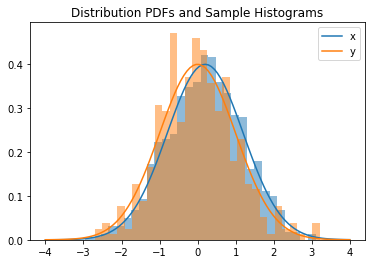

In [9]:
from scipy import stats
import matplotlib.pyplot as plt

# Indeed, the distribution $X$ is stochastically greater the distribution $y$
X = stats.norm(loc=+0.2)
Y = stats.norm(loc=0)
x = X.rvs(size=801)
y = Y.rvs(size=399)

grid = np.linspace(-4, 4, 100)
plt.plot(grid, X.pdf(grid), 'C0')
plt.plot(grid, Y.pdf(grid), 'C1')
plt.hist(x, density=True, color='C0', bins=30, alpha=0.5)
plt.hist(y, density=True, color='C1', bins=30, alpha=0.5)
plt.title('Distribution PDFs and Sample Histograms')
plt.legend(['x', 'y'])
plt.show()

Our first difficulty is determining the correct value of `alternative` to pass into `ks_2samp`. From its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html), we see that the alternatives are expressed not in terms of the values of the samples or the location of the underlying distributions, but in terms of _cumulative density functions_ of the underlying distributions. 

> - `two-sided`: The null hypothesis is that the two distributions are identical, $F(x)=G(x)$ for all $x$; the alternative is that they are not identical.
> - `less`: The null hypothesis is that $F(x) >= G(x)$ for all $x$; the alternative is that $F(x) < G(x)$ for at least one $x$.
> - `greater`: The null hypothesis is that $F(x) <= G(x)$ for all $x$; the alternative is that $F(x) > G(x)$ for at least one $x$.

Note that if a distribution $X$ tends to be greater than $Y$, we find that the cumulative distribution function of $X$ lies _below_ the cumulative distribution function of $Y$.

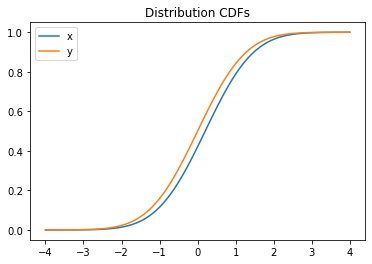

In [10]:
plt.plot(grid, X.cdf(grid), 'C0')
plt.plot(grid, Y.cdf(grid), 'C1')
plt.title('Distribution CDFs')
plt.legend(['x', 'y'])
plt.show()

Therefore, to test the alternative that $X$ is stochastically greater than $Y$, we pass `alternative='less'` into `ks_2samp`.

In [11]:
res1 = stats.ks_2samp(x, y, alternative='less', method='exact')
print(res1)

KstestResult(statistic=0.12484394506866417, pvalue=0.00022195733373729093)


C:\Users\matth\AppData\Local\Temp\ipykernel_35644\3756467023.py:1: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res1 = stats.ks_2samp(x, y, alternative='less', method='exact')


The $p$-value is tiny, confirming what we already know: the data are inconsistent with the null hypothesis, and we have evidence to reject it in favor of the alternative.

The warning states that `ks_2samp` was unable to compute an exact $p$-value, and an asymptotic $p$-value is being returned instead. To determine whether the asymptotic $p$-value is accurate for these sample sizes, we can perform a permutation test.

In [12]:
def statistic(x, y):
    return stats.ks_2samp(x, y, alternative='less').statistic

# This would be extremely slow!
# res2 = stats.permutation_test((x, y), statistic, alternative='greater')

The calculation above would be extremely slow to run. Unfortunately, `ks_2samp` does not accept an `axis` argument, so we can't speed it up using vectorization without truly implementing the statistic ourselves. However, lack of vectorization is not be the bottleneck here. Note that the call to `ks_2samp` is quite slow with the default parameters *even for 1D inputs*.

In [13]:
# No need for the warning; we know the exact calculation is unsuccessful
import warnings
warnings.filterwarnings('ignore')
%timeit stats.ks_2samp(x, y, alternative='less', method='exact')

374 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


By default, `permutation_test` needs to call `ks_2samp` 9999 times, which would take about an hour. We can speed this up dramatically by noting `permutation_test` only uses `ks_2samp` to compute the test statistic, so the `pvalue` attribute of the `ks_2samp` result object is not used at all. We can use `ks_2samp` to compute essentially the same value of the test statistic, but much faster, by specifying `method='asymp'`.

In [14]:
# method='asymp' and method='exact' result in the same statistic value
res1 = stats.ks_2samp(x, y, alternative='less', method='asymp')
res2 = stats.ks_2samp(x, y, alternative='less', method='exact')
np.testing.assert_allclose(res1.statistic, res2.statistic, atol=1e-15)

# but method='asymp' is much faster
%timeit stats.ks_2samp(x, y, alternative='less', method='asymp')

167 µs ± 947 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now we can run a randomized `permutation_test` in reasonable time. 

In [15]:
def statistic(x, y):
    return stats.ks_2samp(x, y, alternative='less', method='asymp').statistic

res3 = stats.permutation_test((x, y), statistic, alternative='less')
print(res1.pvalue, res3.pvalue)

0.0002219573337372917 0.9999


This was much faster, but something is still wrong. Either the approximate $p$-value is wildly inaccurate, or we have set up our test incorrectly. The latter turns out to be the case: the value of `alternative` passed into `ks_2samp` changes *the definition of the test statistic*, but a *greater* p-value is always considered more extreme. Therefore, even if we wish to perform a test equivalent to `ks_2samp` with `alternative='less'`, we actually need to pass `alternative='greater'` into `permutation_test`!

In [16]:
# greater values of the statistic returned by `ks_2samp` are more extreme
res4= stats.permutation_test((x, y), statistic, alternative='greater')
print(res1.pvalue, res4.pvalue)

0.0002219573337372917 0.0005


At last, `permutation_test` is invoked correctly. Indeed, the asymptotic $p$-value produced by `ks_2samp` appears to be reliable for these sample sizes.

### Other Tests
As we can see, `permutation_test` with `permutation_type='independent'` is a versatile tool for comparing independent samples. Provided only data and a statistic, it can produce the null distribution and replicate the $p$-value of many such tests in SciPy, and it may be more accurate than these existing implementations, especially for small samples and when there are ties:

- [`ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
- [`cramervonmises_2samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises_2samp.html)
- [`ks_2samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)
- [`epps_singleton_2samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.epps_singleton_2samp.html)
- [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)
- [`kruskal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)
- [`friedmanchisquare`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html)
- [`brunnermunzel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.brunnermunzel.html)
- [`ansari`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ansari.html)
- [`bartlett`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html)
- [`levene`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html)
- [`anderson_ksamp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html)
- [`fligner`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html)
- [`median_test`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html)
- [`mood`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mood.html)

In addition, `permutation_test` with `permutation_type='independent'` can be used to perform tests not yet implemented in SciPy.

However, there are other types of permutation tests that do not assume that the samples are entirely independent. We continue the study of `permutation_test` with `permutation_type='samples'`.